In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
#from keras_layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [2]:
pip install keras.layer.normalization

Processing c:\users\willi\appdata\local\pip\cache\wheels\85\5d\1c\2e619f594f69fbcf8bc20943b27d414871c409be053994813e\keras_layer_normalization-0.16.0-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [4]:
base_skin_dir = os.path.join('..', 'C:/Users/willi/OneDrive/Desktop/Y3 S1/AI in accounting and Finance/New folder')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [5]:
df = pd.read_csv("C:/Users/willi/OneDrive/Desktop/Y3 S1/AI in accounting and Finance/New folder/HAM10000_metadata.csv")

# Creating New Columns for better readability

df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get) 
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

In [6]:
df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:/Users/willi/OneDrive/Desktop/Y3 S1/AI in ac...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:/Users/willi/OneDrive/Desktop/Y3 S1/AI in ac...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:/Users/willi/OneDrive/Desktop/Y3 S1/AI in ac...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:/Users/willi/OneDrive/Desktop/Y3 S1/AI in ac...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:/Users/willi/OneDrive/Desktop/Y3 S1/AI in ac...,Benign keratosis-like lesions,2
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,C:/Users/willi/OneDrive/Desktop/Y3 S1/AI in ac...,Actinic keratoses,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,C:/Users/willi/OneDrive/Desktop/Y3 S1/AI in ac...,Actinic keratoses,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,C:/Users/willi/OneDrive/Desktop/Y3 S1/AI in ac...,Actinic keratoses,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,C:/Users/willi/OneDrive/Desktop/Y3 S1/AI in ac...,Actinic keratoses,0


In [7]:
df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [8]:

df['age'] = df['age'].fillna(df['age'].median())

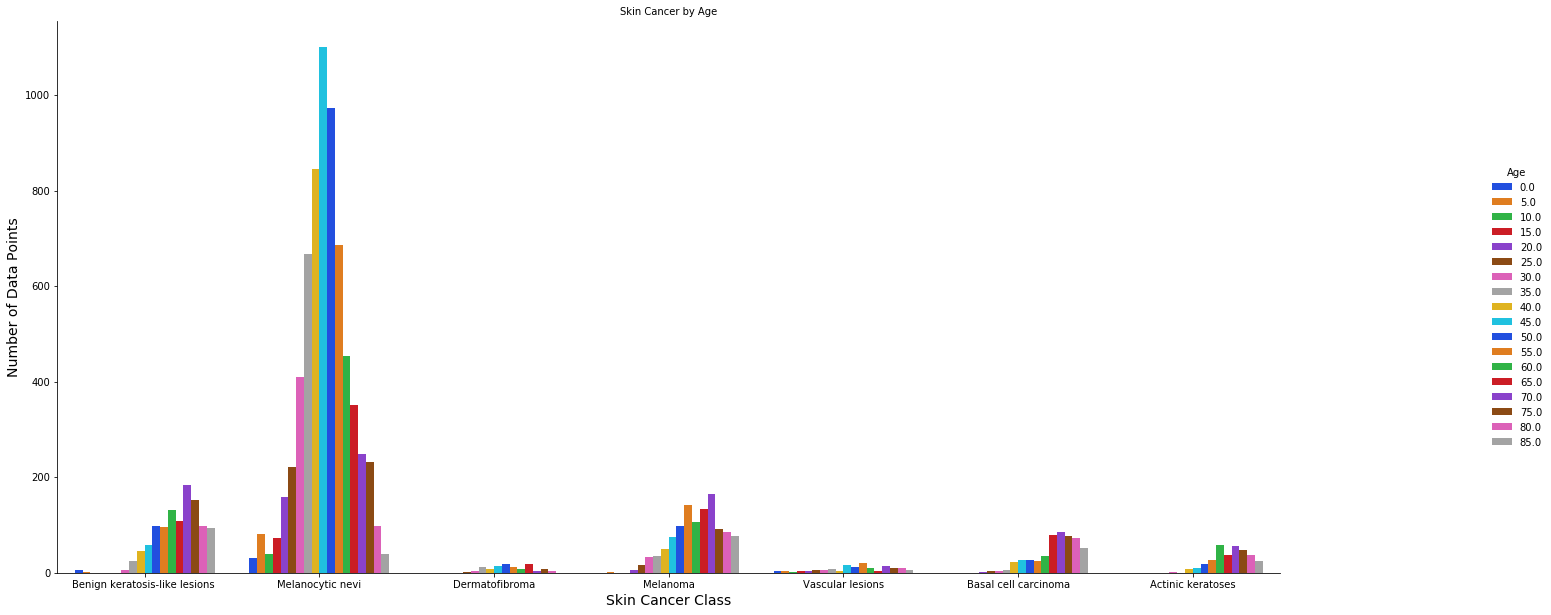

In [9]:
g = sns.catplot(x="cell_type", kind="count", hue="age", palette='bright', data=df)
g.fig.set_size_inches(25, 9)

g.ax.set_title('Skin Cancer by Age', fontsize=10)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Number of Data Points', fontsize=14)
g._legend.set_title('Age')

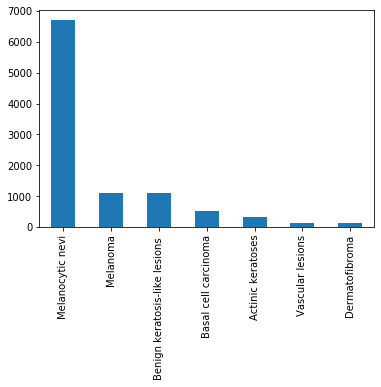

In [10]:
df['cell_type'].value_counts().plot(kind='bar')

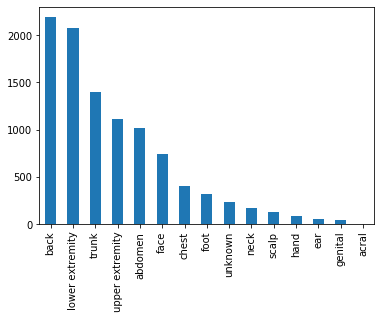

In [11]:
df['localization'].value_counts().plot(kind='bar')

In [12]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:/Users/willi/OneDrive/Desktop/Y3 S1/AI in ac...,Benign keratosis-like lesions,2,"[[[190, 153, 194], [192, 154, 196], [191, 153,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:/Users/willi/OneDrive/Desktop/Y3 S1/AI in ac...,Benign keratosis-like lesions,2,"[[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:/Users/willi/OneDrive/Desktop/Y3 S1/AI in ac...,Benign keratosis-like lesions,2,"[[[185, 127, 137], [189, 133, 147], [194, 136,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:/Users/willi/OneDrive/Desktop/Y3 S1/AI in ac...,Benign keratosis-like lesions,2,"[[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:/Users/willi/OneDrive/Desktop/Y3 S1/AI in ac...,Benign keratosis-like lesions,2,"[[[134, 90, 113], [147, 102, 125], [159, 115, ..."
...,...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,C:/Users/willi/OneDrive/Desktop/Y3 S1/AI in ac...,Actinic keratoses,0,"[[[155, 137, 148], [154, 136, 147], [151, 134,..."
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,C:/Users/willi/OneDrive/Desktop/Y3 S1/AI in ac...,Actinic keratoses,0,"[[[5, 6, 4], [6, 7, 4], [7, 8, 6], [7, 7, 5], ..."
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,C:/Users/willi/OneDrive/Desktop/Y3 S1/AI in ac...,Actinic keratoses,0,"[[[112, 102, 105], [127, 116, 117], [141, 127,..."
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,C:/Users/willi/OneDrive/Desktop/Y3 S1/AI in ac...,Actinic keratoses,0,"[[[159, 122, 146], [159, 123, 141], [154, 112,..."


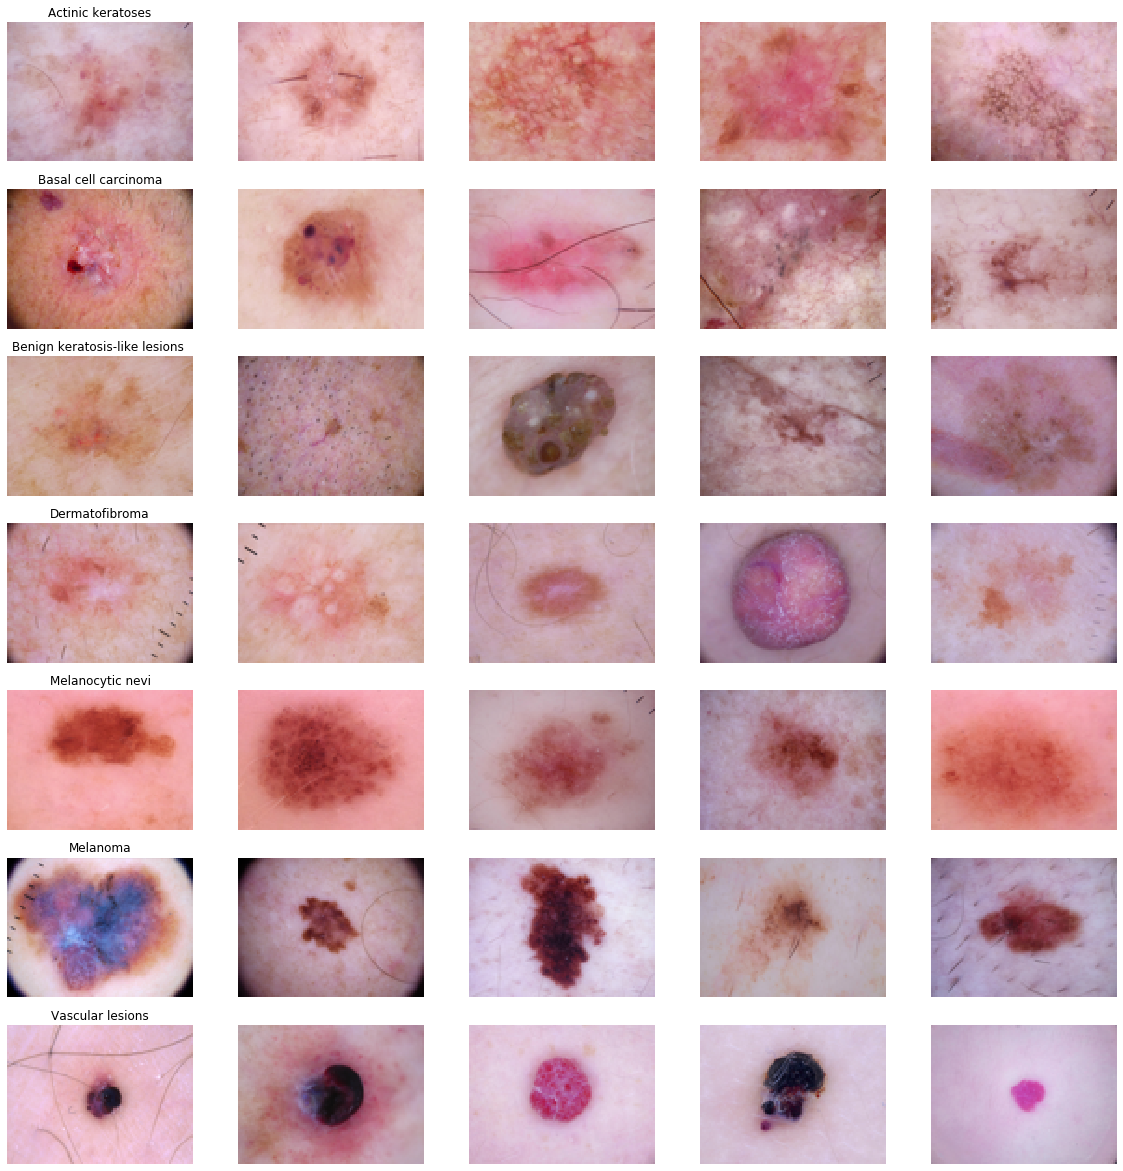

In [13]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)


#https://www.kaggle.com/code/yuningalexliu/dermatology-image-classification

In [14]:
df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:/Users/willi/OneDrive/Desktop/Y3 S1/AI in ac...,Benign keratosis-like lesions,2,"[[[190, 153, 194], [192, 154, 196], [191, 153,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:/Users/willi/OneDrive/Desktop/Y3 S1/AI in ac...,Benign keratosis-like lesions,2,"[[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:/Users/willi/OneDrive/Desktop/Y3 S1/AI in ac...,Benign keratosis-like lesions,2,"[[[185, 127, 137], [189, 133, 147], [194, 136,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:/Users/willi/OneDrive/Desktop/Y3 S1/AI in ac...,Benign keratosis-like lesions,2,"[[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:/Users/willi/OneDrive/Desktop/Y3 S1/AI in ac...,Benign keratosis-like lesions,2,"[[[134, 90, 113], [147, 102, 125], [159, 115, ..."
...,...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,C:/Users/willi/OneDrive/Desktop/Y3 S1/AI in ac...,Actinic keratoses,0,"[[[155, 137, 148], [154, 136, 147], [151, 134,..."
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,C:/Users/willi/OneDrive/Desktop/Y3 S1/AI in ac...,Actinic keratoses,0,"[[[5, 6, 4], [6, 7, 4], [7, 8, 6], [7, 7, 5], ..."
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,C:/Users/willi/OneDrive/Desktop/Y3 S1/AI in ac...,Actinic keratoses,0,"[[[112, 102, 105], [127, 116, 117], [141, 127,..."
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,C:/Users/willi/OneDrive/Desktop/Y3 S1/AI in ac...,Actinic keratoses,0,"[[[159, 122, 146], [159, 123, 141], [154, 112,..."


In [15]:

X = df.drop(columns=["cell_type_idx"], axis=1)
Y = df["cell_type_idx"]

In [16]:
df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:/Users/willi/OneDrive/Desktop/Y3 S1/AI in ac...,Benign keratosis-like lesions,2,"[[[190, 153, 194], [192, 154, 196], [191, 153,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:/Users/willi/OneDrive/Desktop/Y3 S1/AI in ac...,Benign keratosis-like lesions,2,"[[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:/Users/willi/OneDrive/Desktop/Y3 S1/AI in ac...,Benign keratosis-like lesions,2,"[[[185, 127, 137], [189, 133, 147], [194, 136,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:/Users/willi/OneDrive/Desktop/Y3 S1/AI in ac...,Benign keratosis-like lesions,2,"[[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:/Users/willi/OneDrive/Desktop/Y3 S1/AI in ac...,Benign keratosis-like lesions,2,"[[[134, 90, 113], [147, 102, 125], [159, 115, ..."
...,...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,C:/Users/willi/OneDrive/Desktop/Y3 S1/AI in ac...,Actinic keratoses,0,"[[[155, 137, 148], [154, 136, 147], [151, 134,..."
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,C:/Users/willi/OneDrive/Desktop/Y3 S1/AI in ac...,Actinic keratoses,0,"[[[5, 6, 4], [6, 7, 4], [7, 8, 6], [7, 7, 5], ..."
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,C:/Users/willi/OneDrive/Desktop/Y3 S1/AI in ac...,Actinic keratoses,0,"[[[112, 102, 105], [127, 116, 117], [141, 127,..."
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,C:/Users/willi/OneDrive/Desktop/Y3 S1/AI in ac...,Actinic keratoses,0,"[[[159, 122, 146], [159, 123, 141], [154, 112,..."


In [17]:

## do we need split 80:20 Ratio
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,random_state=1)

In [18]:
Y_train

4958    4
2885    1
5395    4
5609    4
6973    4
       ..
2895    1
7813    4
905     2
5192    4
235     2
Name: cell_type_idx, Length: 7511, dtype: int8

In [19]:
## Normalisation 
X_train = np.asarray(X_train['image'].tolist())
X_test = np.asarray(X_test['image'].tolist())


In [20]:
X_train_mean = np.mean(X_train)
X_train_std = np.std(X_train)

X_test_mean = np.mean(X_train)
X_test_std = np.std(X_train)

X_train = (X_train - X_train_mean)/X_train_std
X_test = (X_test - X_test_mean)/X_test_std




In [21]:
# Perform one-hot encoding on the labels
Y_train = to_categorical(Y_train, num_classes = 7)
Y_test = to_categorical(Y_test, num_classes = 7)

In [22]:
X_train

array([[[[ 1.40114104e+00,  2.30469670e-02,  6.04430405e-01],
         [ 1.44420648e+00,  8.76451268e-02,  6.25963125e-01],
         [ 1.50880464e+00,  1.95308726e-01,  6.90561285e-01],
         ...,
         [ 1.48727192e+00,  1.09177847e-01,  4.96766805e-01],
         [ 1.48727192e+00,  1.73776007e-01,  5.61364965e-01],
         [ 1.46573920e+00,  1.52243287e-01,  5.61364965e-01]],

        [[ 1.37960832e+00,  1.51424710e-03,  5.61364965e-01],
         [ 1.42267376e+00,  8.76451268e-02,  6.04430405e-01],
         [ 1.46573920e+00,  1.52243287e-01,  6.47495845e-01],
         ...,
         [ 1.48727192e+00,  1.09177847e-01,  5.61364965e-01],
         [ 1.46573920e+00,  1.09177847e-01,  5.39832245e-01],
         [ 1.42267376e+00,  6.61124069e-02,  4.32168646e-01]],

        [[ 1.40114104e+00,  1.51424710e-03,  5.61364965e-01],
         [ 1.42267376e+00,  6.61124069e-02,  6.04430405e-01],
         [ 1.44420648e+00,  1.52243287e-01,  6.25963125e-01],
         ...,
         [ 1.48727192e+0

In [23]:
Y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [24]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout
model= Sequential()

In [25]:
model.add(Conv2D(32,(3,3), input_shape=(75, 100, 3),activation="relu"))

In [26]:
model.add(MaxPool2D(pool_size=(2,2),strides =2))
model.add(Dropout(0.1))

In [27]:
model.add(Conv2D(32,(3,3),activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides =2))
model.add(Dropout(0.1))

In [28]:
model.add(Conv2D(64,(3,3),activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides =2))
model.add(Dropout(0.1))

In [29]:
model.add(Conv2D(64,(3,3),activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides =2))
model.add(Dropout(0.1))

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 49, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 36, 49, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 47, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 23, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 17, 23, 32)        0

In [31]:
model.add(Flatten())

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 49, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 36, 49, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 47, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 23, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 17, 23, 32)        0

In [33]:
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.1))

In [34]:
#Sigmoid is for unstructured 
#Sigmoid is used for binary classification methods where we only have 2 classes, while SoftMax applies to multiclass problems
model.add(Dense(7,activation ="softmax"))

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 49, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 36, 49, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 47, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 23, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 17, 23, 32)        0

In [36]:
model.compile(loss = "categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [39]:
history = model.fit(X_train, Y_train,
          batch_size=10,
          epochs=40,
          validation_data=(X_test, Y_test))


Epoch 1/40
752/752 [==============================] - 75s 100ms/step - loss: 0.3583 - accuracy: 0.8671 - val_loss: 0.8035 - val_accuracy: 0.7436
Epoch 2/40
752/752 [==============================] - 61s 82ms/step - loss: 0.3440 - accuracy: 0.8717 - val_loss: 0.8102 - val_accuracy: 0.7552
Epoch 3/40
752/752 [==============================] - 71s 95ms/step - loss: 0.3336 - accuracy: 0.8792 - val_loss: 0.8489 - val_accuracy: 0.7576
Epoch 4/40
752/752 [==============================] - 67s 89ms/step - loss: 0.3221 - accuracy: 0.8783 - val_loss: 0.9093 - val_accuracy: 0.7256
Epoch 5/40
752/752 [==============================] - 68s 90ms/step - loss: 0.3132 - accuracy: 0.8828 - val_loss: 0.8856 - val_accuracy: 0.7512
Epoch 6/40
752/752 [==============================] - 69s 92ms/step - loss: 0.3253 - accuracy: 0.8796 - val_loss: 0.9265 - val_accuracy: 0.7376
Epoch 7/40
752/752 [==============================] - 70s 92ms/step - loss: 0.3029 - accuracy: 0.8847 - val_loss: 0.8947 - val_accuracy

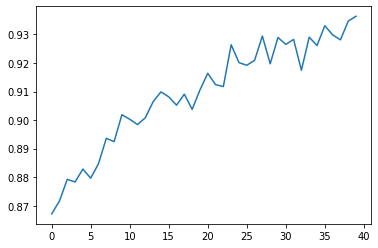

In [40]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])

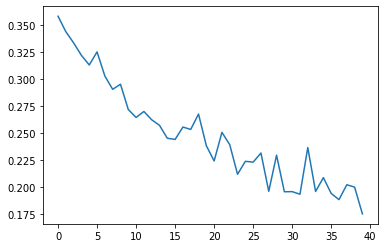

In [41]:
plt.plot(history.history["loss"])

In [42]:
from sklearn.metrics import confusion_matrix

In [43]:
import seaborn as sns

In [47]:
pred = model.predict(X_test)
Y_pred_classes = np.argmax(pred,axis = 1) 
Y_true = np.argmax(Y_test,axis = 1)
cm = confusion_matrix(Y_true, Y_pred_classes) 
confusion_mtx

79/79 [==============================] - 3s 41ms/step


array([[  26,   22,    6,    3,   22,    5,    0],
       [   9,   64,   17,    2,   21,    5,    4],
       [   8,   13,  118,    0,  118,   26,    0],
       [   4,   14,    2,    7,    9,    2,    2],
       [   7,   14,   53,    5, 1514,   65,    3],
       [   4,    7,   33,    1,  122,  103,    1],
       [   0,    5,    0,    1,   12,    3,   22]], dtype=int64)

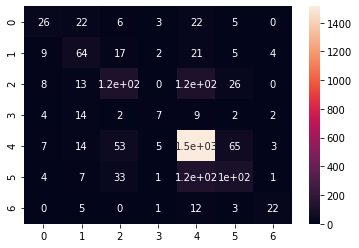

In [48]:
print("accuracy is",(cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3]+cm[4,4]+cm[5,5]+cm[6,6])/(sum(sum(cm))))

accuracy is 0.7404153354632588
